In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [4]:
DATA_DIR = '../data/Останкино'

In [5]:
PROFMERS_TRAIN_DIR = os.path.join(DATA_DIR, 'historic_data', 'Профилемер')
STATIONS_TRAIN_DIR = os.path.join(DATA_DIR, 'historic_data', 'Останкино 0 метео 2015-2020 г')
COMPONENTS_TRAIN =  os.path.join(DATA_DIR, 'historic_data', 'Останкино 2015-2020гг_components.xlsx')

In [6]:
SEED = 1

In [7]:
files_profmers = [os.path.join(PROFMERS_TRAIN_DIR, obj) for obj in os.listdir(PROFMERS_TRAIN_DIR) if os.path.isfile(os.path.join(PROFMERS_TRAIN_DIR, obj))]

In [8]:
def get_skip_rows_num(file_path):
    """
    Find row number where dataframe starts
    """
    row_count = 0

    with open(file_path) as f:
         for l in f.readlines():
            if l.startswith('data'):
                break
            row_count += 1
    return row_count

In [9]:
def get_components_data(file_path):
    """
    Each sheet corresponds to a year
    """
    df = []
    sheets = pd.read_excel(file_path, sheet_name=None, engine='openpyxl')

    for k, sheet in sheets.items():
        df.append(sheet)
    if len(df) != 0:
        df = pd.concat(df)
        
    return df

In [10]:
#  profilemers
df_profmers = []
df = pd.DataFrame()

for file_path in files_profmers:
    skiprows = get_skip_rows_num(file_path)
    try:
        df = pd.read_csv(file_path, sep="\t", skiprows=skiprows, decimal=',')
    except pd.errors.EmptyDataError:
        continue
    df['datetime'] = pd.to_datetime(df['data time'], dayfirst=True)
    df.set_index('datetime', inplace=True)
    df_profmers.append(df)

df_pr = pd.concat(df_profmers)
df_pr.sort_index(inplace=True) 

In [11]:
df_pr = df_pr.reset_index()
df_pr.head(2)

,datetime,data time,0,50,100,150,200,250,300,350,...,Unnamed: 21,Unnamed: 22,650,700,750,800,850,900,950,1000
0,2015-01-01 00:00:00,01/01/2015 00:00:00,-6.73,-7.42,-7.94,-8.52,-8.88,-8.99,-8.90,-8.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:05:00,01/01/2015 00:05:00,-6.72,-7.29,-7.93,-8.49,-8.66,-8.88,-8.96,-8.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_components = get_components_data(COMPONENTS_TRAIN)
df_components = df_components.dropna(subset=['Дата и время']).reset_index(drop=True)

In [23]:
df_components.head(2)

,Дата и время,CO,NO2,NO,PM10,PM2.5
0,01/01/2015 00:00,0.2,0.009,0.002,0.007,NaN
1,01/01/2015 00:20,0.2,0.010,0.002,0.008,NaN


In [24]:
df_components['datetime'] = pd.to_datetime(df_components['Дата и время'], dayfirst=True)

In [25]:
# station
station_dfs = []
for station in os.listdir(STATIONS_TRAIN_DIR):
    if os.path.splitext(station)[1] != '.xlsx':
        continue
    df_station = pd.read_excel(os.path.join(STATIONS_TRAIN_DIR, station), engine='openpyxl')
    df_station = df_station[1:].reset_index(drop=True)
    station_dfs.append(df_station)

In [26]:
df_station = pd.concat(station_dfs)

In [27]:
df_station['datetime'] = pd.to_datetime(df_station['Дата и время'])
df_station.head(2)

,Дата и время,Давление,Влажность,| V |,_V_,-T-,Осадки,Дальность видимости,"Текущая погода, код по SYNOP","Погода за текущие 15 мин, код по SYNOP",...,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,datetime
0,01/01/2019 00:00,754.3,72.0,1.3,197.0,-4.0,0.0,1309.0,10.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
1,01/01/2019 00:20,754.3,72.0,0.8,190.0,-4.0,0.0,1315.0,10.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:20:00


In [28]:
df_components = df_components.drop(columns=['Дата и время'])
df_station = df_station.drop(columns=['Дата и время'])
df_pr = df_pr.drop(columns=['data time'])

In [29]:
def round_time(tm, min_interval=10):
    discard = pd.Timedelta(minutes=tm.minute % min_interval,
                           seconds=tm.second,
                           microseconds=tm.microsecond)
    tm -= discard
    if discard >= pd.Timedelta(minutes=min_interval/2):
        tm += pd.Timedelta(minutes=min_interval)

    return tm

In [30]:
df_station['datetime'] = df_station['datetime'].apply(lambda x: round_time(x, 10))
df_components['datetime'] = df_components['datetime'].apply(lambda x: round_time(x, 10))
df_pr['datetime'] = df_pr['datetime'].apply(lambda x: round_time(x, 5))

In [31]:
df_X = pd.merge(df_station, df_pr, how='left', on='datetime')
df_X = pd.merge(df_X, df_components, how='left', on='datetime')

In [32]:
df_X.shape

(157824, 68)

In [33]:
df_X['hour'] = df_X['datetime'].apply(lambda x: x.hour)
df_X['dayofweek'] = df_X['datetime'].apply(lambda x: x.dayofweek)
df_X['month'] = df_X['datetime'].apply(lambda x: x.month)
df_X['day'] = df_X['datetime'].apply(lambda x: x.day)

In [34]:
# Drop features if all values are missing
df_t = df_X.isnull().all()
cols_to_drop = df_t[df_t == True].index.to_list()

# Drop features if there are only one unique value
for feature in df_X.columns:
    if df_X[feature].nunique() == 1:
        cols_to_drop.append(feature)

# Drop deprecated time data
drop_ = ['650', '700', '750', '800', '850', '900', '950', '1000',
         'Дальность видимости', 'Текущая погода, код по SYNOP', 'Погода за текущие 15 мин, код по SYNOP',
         'Погода за текущий час, код по SYNOP', 'Интенсивность дождя', 'Количество осадков, дождь',
         'Количество осадков, снег', 'Температура поперечины FS11P', 'Яркость фона']

cols_to_drop.extend(drop_)

print('Features to drop:', cols_to_drop)
df_X = df_X.drop(columns=cols_to_drop)

Features to drop: ['Unnamed: 16_x', 'Unnamed: 17_x', 'Unnamed: 18_x', 'Unnamed: 19_x', 'Unnamed: 20_x', 'Unnamed: 21_x', 'Unnamed: 22_x', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 15', 'Unnamed: 16_y', 'Unnamed: 17_y', 'Unnamed: 18_y', 'Unnamed: 19_y', 'Unnamed: 20_y', 'Unnamed: 21_y', 'Unnamed: 22_y', '650', '700', '750', '800', '850', '900', '950', '1000', 'Дальность видимости', 'Текущая погода, код по SYNOP', 'Погода за текущие 15 мин, код по SYNOP', 'Погода за текущий час, код по SYNOP', 'Интенсивность дождя', 'Количество осадков, дождь', 'Количество осадков, снег', 'Температура поперечины FS11P', 'Яркость фона']


In [35]:
# data by hour
df_X = df_X.sort_values(by=['datetime'])
df_X = df_X.resample('60min', on='datetime').first().drop(columns=['datetime']).reset_index()

In [36]:
df_X.drop(columns=['datetime'], inplace=True)

In [37]:
df_X.columns

Index(['Давление', 'Влажность', '| V |', '_V_', '-T-', 'Осадки', '0', '50',
       '100', '150', '200', '250', '300', '350', '400', '450', '500', '550',
       '600', 'OutsideTemperature', 'Quality', 'CO', 'NO2', 'NO', 'PM10',
       'PM2.5', 'hour', 'dayofweek', 'month', 'day'],
      dtype='object')

In [38]:
def create_dataset(X, y, window_size, past_agg_window):
    Xs = []
    ys = []
    s = ['hour', 'month', 'day', 'dayofweek']
    w = ['-T-', '| V |', 'Давление', 'Влажность', 'Осадки']
    columns = ['Давление', 'Влажность', '| V |', '_V_', '-T-', 'Осадки', '0', '50',
               '100', '150', '200', '250', '300', '350', '400', '450', '500', '550',
               '600', 'OutsideTemperature', 'Quality', 'CO', 'NO2', 'NO', 'PM10',
               'PM2.5']
    
    d = X[s]
    X = X[columns]

    for i in range(0, X.shape[0] - window_size):
        if np.any(np.isnan(y.iloc[i+window_size].values)):  # filtering out target values with NaN
            continue
        previous_max = X.iloc[i-2*past_agg_window:i].max()
        previous_min = X.iloc[i-2*past_agg_window:i].min()
        
        previous_min_1 = X.iloc[i-1*past_agg_window:i].min()
        
        current_d = d.iloc[i][['hour', 'month', 'dayofweek']]
        
        future_w = X.iloc[i+window_size][w]
        
        data = pd.concat([X.iloc[i], previous_max, previous_min, previous_min_1, current_d, future_w])
        Xs.append(data)
        ys.append(y.iloc[i+window_size])
        
    return np.array(Xs), np.array(ys).flatten()

In [90]:
X, y = df_X[:15000], df_X[:15000][['NO']]

In [91]:
WINDOW_SIZE = 24

In [92]:
X, y = create_dataset(X, y, WINDOW_SIZE, 2)

In [93]:
model = CatBoostRegressor(random_state=SEED, verbose=0)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=SEED,
                                                    test_size=0.2,
                                                    shuffle=False)

In [95]:
model.fit(X_train, y_train)

In [96]:
y_pred = model.predict(X_test)

In [97]:
y_pred = np.where(y_pred < 0, 0, y_pred)

In [1988]:
-cross_val_score(model, X_test, y_test, cv=3, scoring='neg_mean_squared_error').mean()

0.0004791252551901818

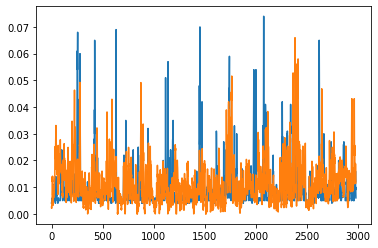

In [98]:
plt.plot(y_test)

plt.plot(y_pred)

plt.show()

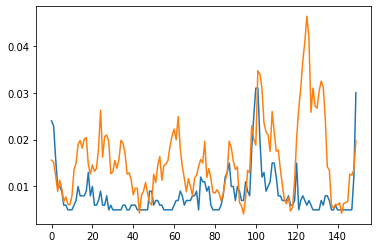

In [99]:
plt.plot(y_test[100:250])

plt.plot(y_pred[100:250])

plt.show()

In [2047]:
import pickle

In [2048]:
# train models for each component and for each hour in the next 24 hours
NO2_models = {}

for i in tqdm.trange(1, 25):
    X, y = df_X, df_X[['NO2']]
    X, y = create_dataset(X, y, i, 2)
    model = CatBoostRegressor(random_state=SEED, verbose=0)
    model.fit(X, y)
    NO2_models[i] = model

100%|██████████| 24/24 [50:38<00:00, 126.60s/it]


In [2049]:
for i, m in NO2_models.items():
    with open(f'model_{i}_hour_NO2.pkl', 'wb') as f:
        pickle.dump(m, f)